In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal as mvn

import seaborn as sns

import dcor

from jax import grad
import jax.numpy as jnp
import jax.scipy.stats.multivariate_normal as jmvn
from jax.scipy.stats import gaussian_kde as jgaussian_kde

from stein_thinning.thinning import thin, thin_gf, _make_stein_integrand, _make_stein_gf_integrand
from stein_thinning.stein import kmat

from utils.ksd import calculate_ksd
from utils.mvn import make_mvn_mixture
from utils.plotting import centered_subplots, highlight_points, plot_density

In [2]:
figures_path = Path('../report') / 'figures'

## Generate from a multivariate normal mixture model

For multivariate normal distributions with pdfs
$$f_i(x) = \frac{1}{(2\pi)^{d/2} |\Sigma_i|^{1/2}}\exp\left(-\frac{1}{2}(x - \mu_i)^T \Sigma_i^{-1}(x-\mu_i)\right),$$
where $x \in \mathbb{R}^d$, the mixture pdf with $k$ components is given by
$$f(x) = \sum_{i=1}^k w_i f_i(x),$$
thus the score function is obtained as
$$\nabla \log f(x) = \frac{\sum_{i=1}^k w_i \nabla f_i(x)}{\sum_{i=1}^k w_i f_i(x)} = -\frac{\sum_{i=1}^k w_i f_i(x) \Sigma_i^{-1}(x - \mu_i)}{\sum_{i=1}^k w_i f_i(x)}.$$

Define the functions for the parameters of a multivariate Gaussian mixture:

Choose the parameters of the mixture:

In [3]:
weights = np.array([0.3, 0.7])
means = np.array([
    [-1., -1.],
    [1., 1.],
])
covs = np.array([
    [
        [0.5, 0.25],
        [0.25, 1.],
    ],
    [
        [2.0, -np.sqrt(3.) * 0.8],
        [-np.sqrt(3.) * 0.8, 1.5],
    ]
])

In [4]:
rvs, logpdf, score, logpdf_jax = make_mvn_mixture(weights, means, covs)

Obtain a sample from the mixture:

In [5]:
rng = np.random.default_rng(12345)

In [6]:
sample_size = 1000

In [7]:
sample = rvs(sample_size, random_state=rng)

We plot the sample (a) and the mixture density (b):

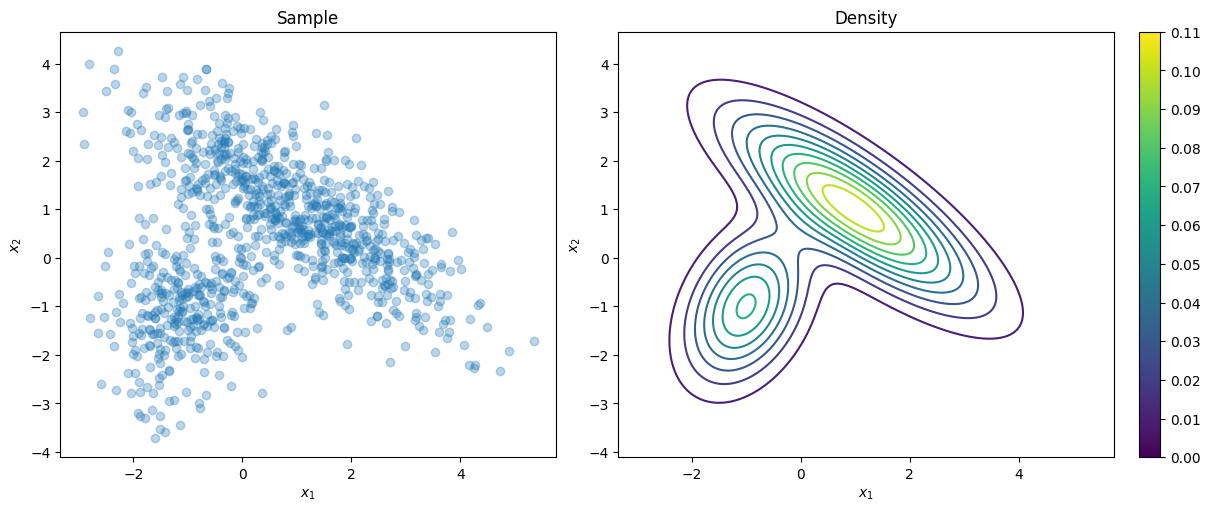

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
axs[0].scatter(sample[:, 0], sample[:, 1], alpha=0.3);
axs[0].set_title('Sample');
axs[0].set_xlabel('$x_1$');
axs[0].set_ylabel('$x_2$');

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Density', levels=10, fill=False,
             colorbar=True, level_labels=False)
axs[1].set_xlabel('$x_1$');
axs[1].set_ylabel('$x_2$');

fig.savefig(figures_path / 'gaussian-mixture-sample.pdf');

Verify log-pdf against the JAX implementation:

In [9]:
np.testing.assert_allclose(logpdf(sample), logpdf_jax(sample), rtol=1e-4)

Verify the score function against the JAX implementation:

In [10]:
gradient = score(sample)

In [11]:
score_jax = grad(logpdf_jax)
gradient_jax = jnp.apply_along_axis(score_jax, 1, sample)

In [12]:
np.testing.assert_array_almost_equal(gradient, gradient_jax)

## Thinning

Our aim here is to select a subsample of the posterior sample that best represents the posterior distribution.

In [13]:
thinned_size = 1000
n_points_display = 40

### Naive thinning

The easiest way to obtain a subsample from the posterior sample is by retaining each i-th element. In this case, each point is selected independently with the same probability.

In [14]:
def naive_thin(n_total_points, thinned_size):
    return np.linspace(0, n_total_points - 1, thinned_size).astype(int)

In [15]:
idx_naive = naive_thin(sample.shape[0], n_points_display)

### Stein thinning

If the gradient of the log-posterior is available, we can use it to perform thinning based on kernel Stein discrepancy:

In [16]:
idx_st = thin(sample, gradient, thinned_size)

### Gradient-free Stein thinning with a simple Gaussian proxy

For gradient-free Stein thinning, we need need the posterior probability for each sample point:

In [17]:
log_p = logpdf(sample)
p = np.exp(log_p)

When the gradient of the log-posterior is not available, we can resort to a gradient-free approximation. This requires us to select a proxy distribution whose gradient is easily computable. The simplest option is to select a multivariate Gaussian with moments matching the sample:

In [18]:
sample_mean = np.mean(sample, axis=0)
sample_cov = np.cov(sample, rowvar=False, ddof=1)

In [19]:
sample_mean

array([0.37127232, 0.35813142])

In [20]:
sample_cov

array([[2.51131846, 0.00893545],
       [0.00893545, 2.16606407]])

Gradient-free Stein thinning requires us to provide the log-pdf of the proxy distribution and its score function:

In [21]:
log_q = mvn.logpdf(sample, mean=sample_mean, cov=sample_cov)
gradient_q = -np.einsum('ij,kj->ki', np.linalg.inv(sample_cov), sample - sample_mean)

We get the indices of the points to select:

In [22]:
idx_gf = thin_gf(sample, log_p, log_q, gradient_q, thinned_size)

### Gradient-free Stein thinning with a KDE proxy

We can obtain a better approximation of the posterior with a KDE of the sample:

In [23]:
kde = jgaussian_kde(sample.T, bw_method='silverman')

We plot the KDE density against the true mixture density:

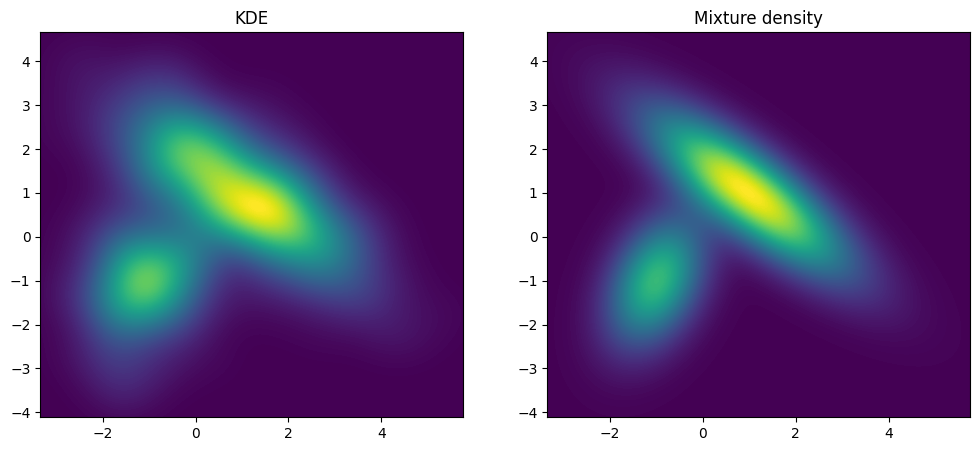

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_density(lambda x: np.exp(kde.logpdf(x.T)), axs[0], xlim, ylim, 'KDE');
plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Mixture density');

For simplicity, we obtain the gradient by numerical differentiation. Since the default choice of kernel for KDE is Gaussian, we could also obtain the gradient explicitly.

In [25]:
def logpdf_and_score(kde, sample):
    log_q = np.array(kde.logpdf(sample.T))
    kde_grad = grad(lambda x: kde.logpdf(x)[0])
    gradient_q = np.array(jnp.apply_along_axis(kde_grad, 1, sample))
    return log_q, gradient_q

In [26]:
log_q_kde, gradient_q_kde = logpdf_and_score(kde, sample)

In [27]:
idx_gf_kde = thin_gf(sample, log_p, log_q_kde, gradient_q_kde, thinned_size)

### Gradient-free Stein thinning with a weighted KDE proxy

A further improvement on the KDE approach is to use the posterior probabilities of the sample points as weights in the KDE approximation:

In [28]:
w = p / np.sum(p)
wkde = jgaussian_kde(sample.T, bw_method='silverman', weights=w)
log_q_wkde, gradient_q_wkde = logpdf_and_score(wkde, sample)

We plot the resulting KDE density against the true mixture density:

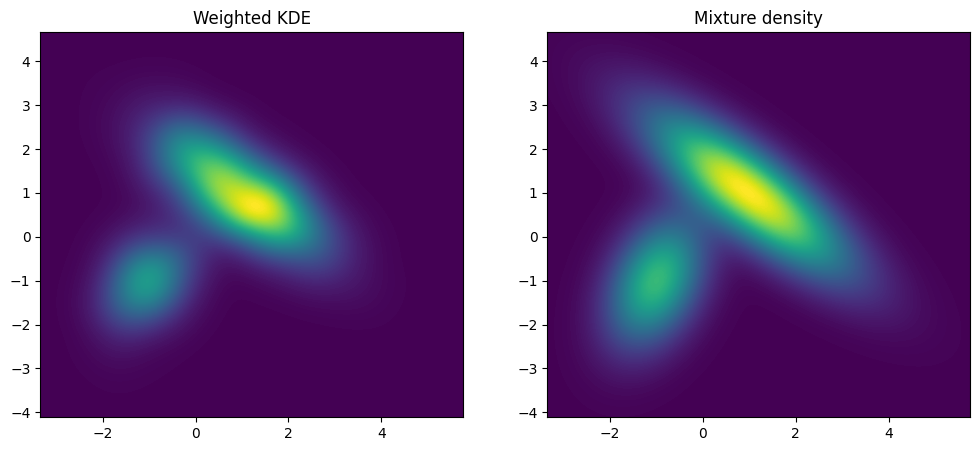

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_density(lambda x: np.exp(wkde.logpdf(x.T)), axs[0], xlim, ylim, 'Weighted KDE');
plot_density(lambda x: np.exp(logpdf(x)), axs[1], xlim, ylim, 'Mixture density');

In [30]:
idx_gf_wkde = thin_gf(sample, log_p, log_q_wkde, gradient_q_wkde, thinned_size)

### Gradient-free Stein thinning with a Laplace approximation

In [31]:
def laplace_approximation(sample):
    res = minimize(lambda x: -logpdf(x), np.mean(sample, axis=0), method='BFGS')
    assert res.success
    return res.x, res.hess_inv

In [32]:
laplace_mean, laplace_cov = laplace_approximation(sample)

In [33]:
laplace_mean

array([0.96124667, 1.02187361])

In [34]:
laplace_cov

array([[ 2.00636653, -1.3359801 ],
       [-1.3359801 ,  1.43121009]])

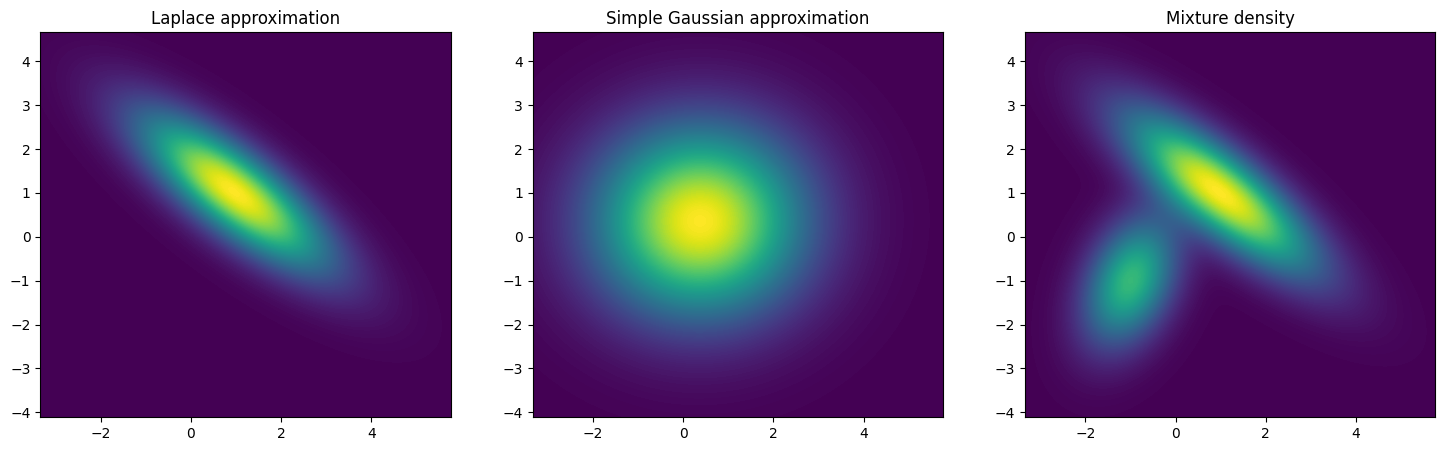

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
plot_density(lambda x: mvn.pdf(x, mean=laplace_mean, cov=laplace_cov), axs[0], xlim, ylim, 'Laplace approximation');
plot_density(lambda x: mvn.pdf(x, mean=sample_mean, cov=sample_cov), axs[1], xlim, ylim, 'Simple Gaussian approximation');
plot_density(lambda x: np.exp(logpdf(x)), axs[2], xlim, ylim, 'Mixture density');

In [36]:
log_q_laplace = mvn.logpdf(sample, mean=laplace_mean, cov=laplace_cov)
gradient_q_laplace = -np.einsum('ij,kj->ki', np.linalg.inv(laplace_cov), sample - laplace_mean)

In [37]:
idx_gf_laplace = thin_gf(sample, log_p, log_q_laplace, gradient_q_laplace, thinned_size)

/home/artem/git/stein_thinning/stein_thinning/thinning.py:126: UserWarning: log_q differs from log_p by more than 10 - consider using q that matches target better
  warnings.warn(f'log_q differs from log_p by more than {WEIGHT_SCALE_THRESHOLD} - consider using q that matches target better')


### Comparison

In [38]:
entries = [
    (idx_naive, 'Naïve thinning'),
    (idx_st, 'Stein thinning'),
    (idx_gf, 'Gradient-free Stein thinning: simple Gaussian'),
    (idx_gf_kde, 'Gradient-free Stein thinning: KDE'),
    (idx_gf_wkde, 'Gradient-free Stein thinning: weighted KDE'),
    (idx_gf_laplace, 'Gradient-free Stein thinning: Laplace approximation'),
]

The number of unique point selected:

In [39]:
def create_table(idx_func, entries):
    return pd.Series([idx_func(idx) for idx, _ in entries], index=[title for _, title in entries])

In [40]:
create_table(lambda idx: len(np.unique(idx)), entries)

Naïve thinning                                          40
Stein thinning                                         608
Gradient-free Stein thinning: simple Gaussian          527
Gradient-free Stein thinning: KDE                      588
Gradient-free Stein thinning: weighted KDE             544
Gradient-free Stein thinning: Laplace approximation      1
dtype: int64

Plot the selected points:

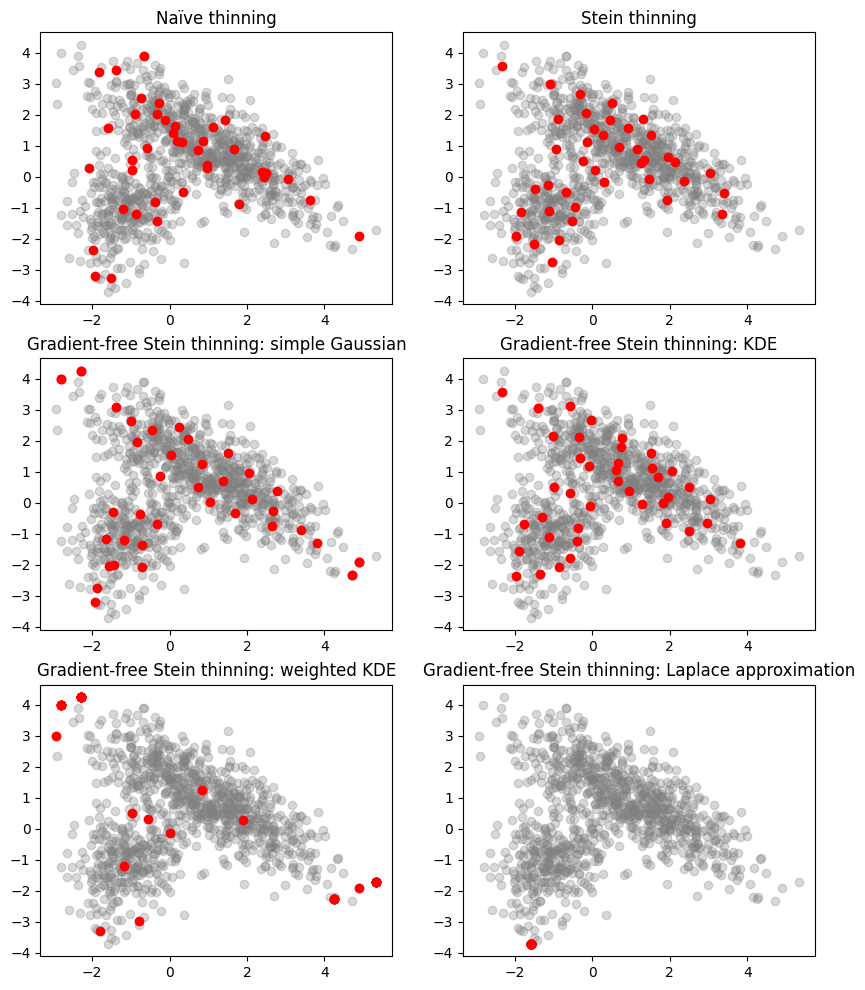

In [41]:
n_cols = 2
n_rows = (len(entries) - 1) // n_cols + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4));
for i, (idx, title) in enumerate(entries):
    ax = axs[i // 2][i % 2]
    highlight_points(
        sample,
        idx[:n_points_display],
        coord_spec=[(0, 1)],
        axs=[ax],
        sample_point_color='grey',
        sample_point_size=None,
    )
    ax.set_title(title);

Produce the figure for the report:

In [42]:
entries_report = [
    (idx_naive, 'Naïve thinning'),
    (idx_st, 'Stein thinning'),
    (idx_gf, 'Gradient-free Stein thinning: simple Gaussian'),
    (idx_gf_kde, 'Gradient-free Stein thinning: KDE'),
    (idx_gf_laplace, 'Gradient-free Stein thinning: Laplace approximation'),
]

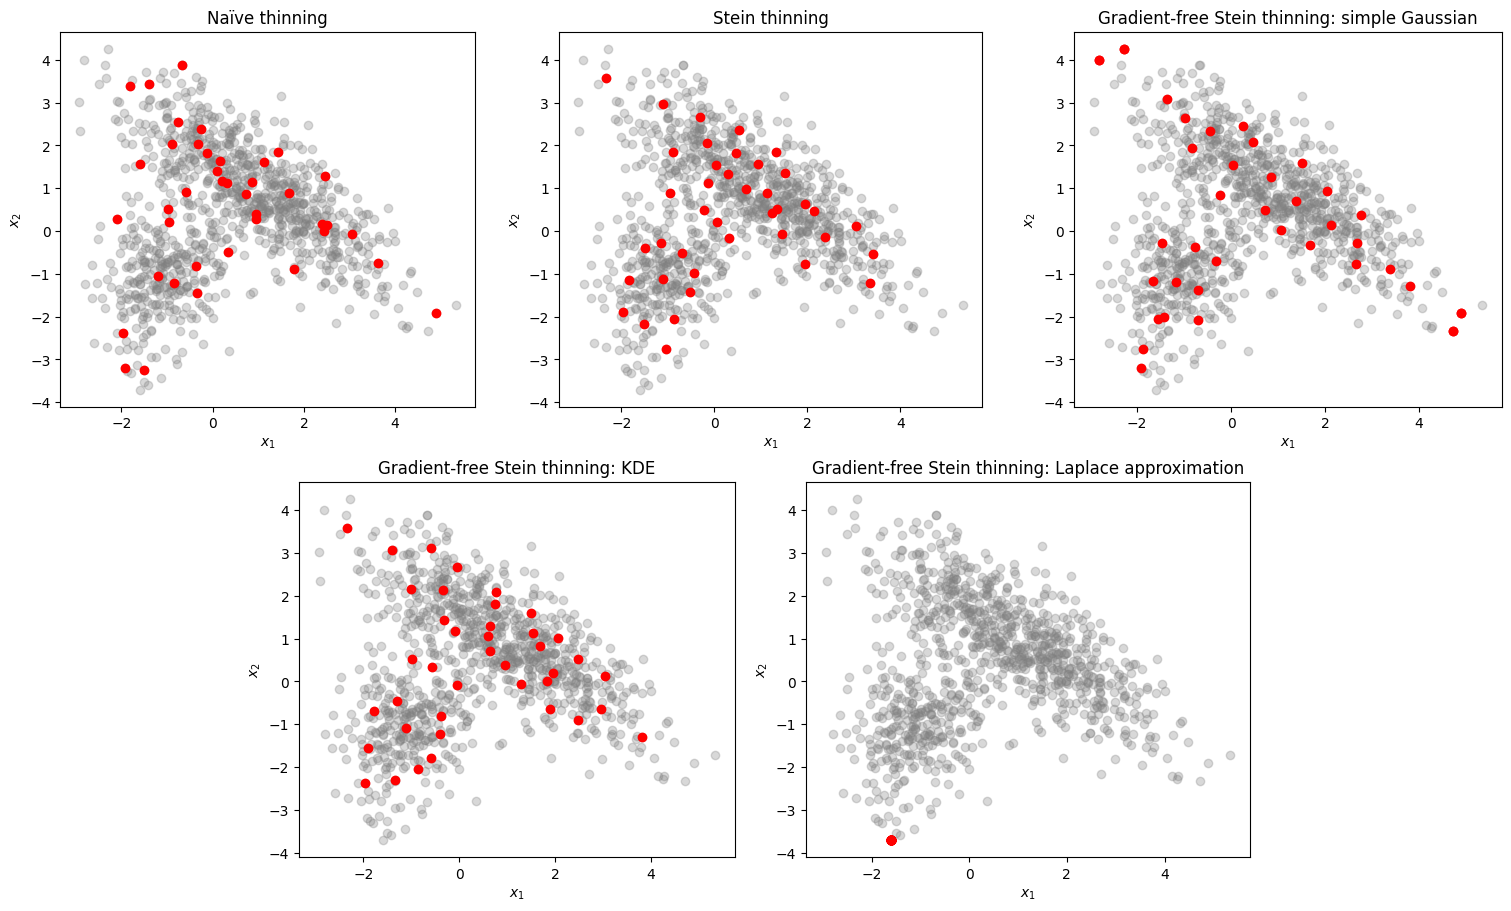

In [43]:
fig = plt.figure(constrained_layout=True, figsize=(15, 9))
axs = centered_subplots(fig, [3, 2])
for i, (idx, title) in enumerate(entries_report):
    ax = axs[i]
    highlight_points(
        sample,
        idx[:n_points_display],
        coord_spec=[(0, 1)],
        axs=[ax],
        sample_point_color='grey',
        sample_point_size=None,
    )
    ax.set_title(title);
    ax.set_xlabel('$x_1$');
    ax.set_ylabel('$x_2$');

fig.savefig('../report/figures/gaussian-mixture-thinned-20.pdf');

#### Energy distance

Compare the energy distance to the full posterior sample:

In [44]:
create_table(lambda idx: np.sqrt(dcor.energy_distance(sample[idx[:n_points_display]], sample)), entries)

Naïve thinning                                         0.200956
Stein thinning                                         0.116144
Gradient-free Stein thinning: simple Gaussian          0.371942
Gradient-free Stein thinning: KDE                      0.095249
Gradient-free Stein thinning: weighted KDE             1.245123
Gradient-free Stein thinning: Laplace approximation    2.616142
dtype: float64

To evaluate how well the thinned sample approximates the true distribution, we draw a new sample from the distribution and calculate the energy distance:

In [45]:
sample2 = rvs(sample_size, random_state=rng)

In [46]:
create_table(lambda idx: np.sqrt(dcor.energy_distance(sample[idx[:n_points_display]], sample2)), entries)

Naïve thinning                                         0.208667
Stein thinning                                         0.104302
Gradient-free Stein thinning: simple Gaussian          0.410703
Gradient-free Stein thinning: KDE                      0.109114
Gradient-free Stein thinning: weighted KDE             1.270934
Gradient-free Stein thinning: Laplace approximation    2.641829
dtype: float64

#### Energy distance plots

In [47]:
naive_st = [np.sqrt(dcor.energy_distance(sample[naive_thin(sample.shape[0], n)], sample2)) for n in range(1, thinned_size + 1)]

In [48]:
entries_ed = [
    (idx_st, 'Stein'),
    (idx_gf, 'Gradient-free: simple Gaussian'),
    (idx_gf_kde, 'Gradient-free: KDE'),
]

In [49]:
%%time
ed_vals = [
    [np.sqrt(dcor.energy_distance(sample[entry[0][:m]], sample2)) for m in range(1, thinned_size + 1)]
    for entry in entries_ed
]

CPU times: user 28.9 s, sys: 3.44 s, total: 32.3 s
Wall time: 32.3 s


In [50]:
%%time
ksd_vals = [calculate_ksd(sample, gradient, entry[0]) for entry in entries_ed]

CPU times: user 715 ms, sys: 3.98 ms, total: 719 ms
Wall time: 719 ms


In [51]:
%%time
ksd_naive = [
    calculate_ksd(sample, gradient, naive_thin(sample.shape[0], m)) for m in range(1, thinned_size + 1)
]

CPU times: user 1min 44s, sys: 32.7 ms, total: 1min 44s
Wall time: 1min 44s


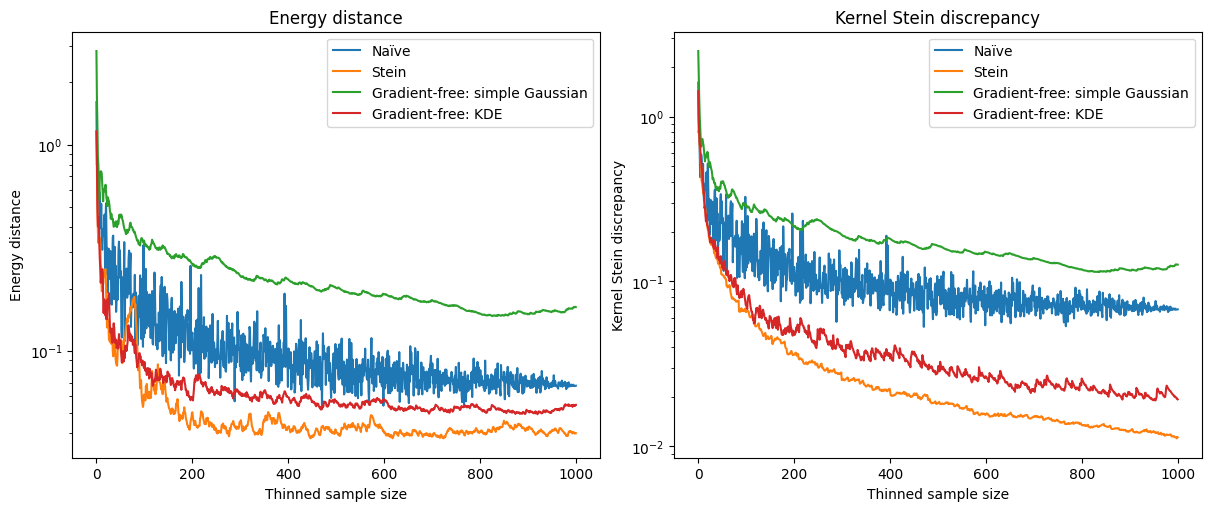

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

axs[0].plot(naive_st, label='Naïve');
for i, entry in enumerate(entries_ed):
    axs[0].plot(ed_vals[i], label=entry[1]);
axs[0].set_yscale('log');
axs[0].set_xlabel('Thinned sample size');
axs[0].set_ylabel('Energy distance');
axs[0].legend();
axs[0].set_title('Energy distance');

axs[1].plot(naive_st, label='Naïve');
for i, entry in enumerate(entries_ed):
    axs[1].plot(ksd_vals[i], label=entry[1]);
axs[1].set_yscale('log');
axs[1].set_xlabel('Thinned sample size');
axs[1].set_ylabel('Kernel Stein discrepancy');
axs[1].legend();
axs[1].set_title('Kernel Stein discrepancy');

fig.savefig(figures_path / 'gaussian-mixture-comparison.pdf');

#### Performance of weighted KDE

We have seen that the performance of the gradient-free algorithm with a weighted KDE is unsatisfactory. The scatter plot of the selected points suggests that the algorithm picks points that have a low probability. We can confirm this by highlighting the points with the lowest probability in the sample:

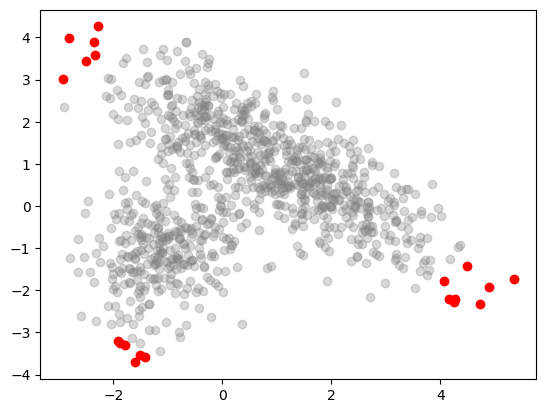

In [53]:
highlight_points(
    sample,
    np.argsort(log_q)[:20],
    coord_spec=[(0, 1)],
    sample_point_color='grey',
    sample_point_size=None,
);

The gradient-free integrand includes the multiplier $q(x)/p(x)$. In the plain KDE, $q(x)$ will be proportional to the density of sample points in te vicinity of $x$. Applying weights has the effect of reducing $q(x)$ further, thus penalising the points in the low-probability area twice.

We can confirm that the values of $\log q(x) - \log p(x)$ are commensurate across the sample for the standard KDE but not for the weighted KDE:

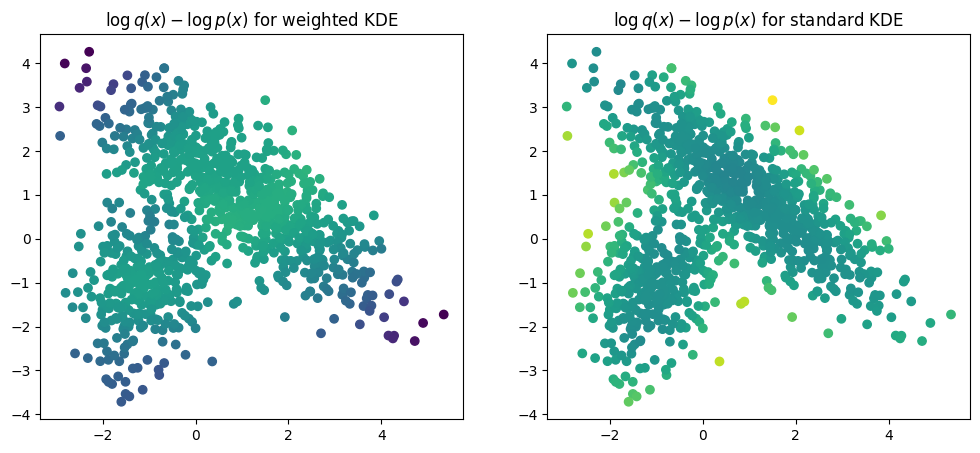

In [54]:
vals = np.concatenate([log_q_wkde - log_p, log_q_kde - log_p])
vmin = np.min(vals)
vmax = np.max(vals)

fig, axs = plt.subplots(1, 2, figsize=(12, 5));

scatter = axs[0].scatter(sample[:, 0], sample[:, 1], c=log_q_wkde - log_p, vmin=vmin, vmax=vmax);
axs[0].set_title('$\\log q(x) - \\log p(x)$ for weighted KDE');

axs[1].scatter(sample[:, 0], sample[:, 1], c=log_q_kde - log_p, vmin=vmin, vmax=vmax);
axs[1].set_title('$\\log q(x) - \\log p(x)$ for standard KDE');

Here we compare the values on the diagonal of the integrand matrix, which the algorithm would use in its first step:

In [55]:
integrand_st = _make_stein_integrand(sample, gradient)
integrand_kde = _make_stein_gf_integrand(sample, log_p, log_q_kde, gradient_q_kde)
integrand_wkde = _make_stein_gf_integrand(sample, log_p, log_q_wkde, gradient_q_wkde)

In [56]:
integrands = [integrand_st, integrand_kde, integrand_wkde]
kmats = [kmat(integrand, sample.shape[0]) for integrand in integrands]

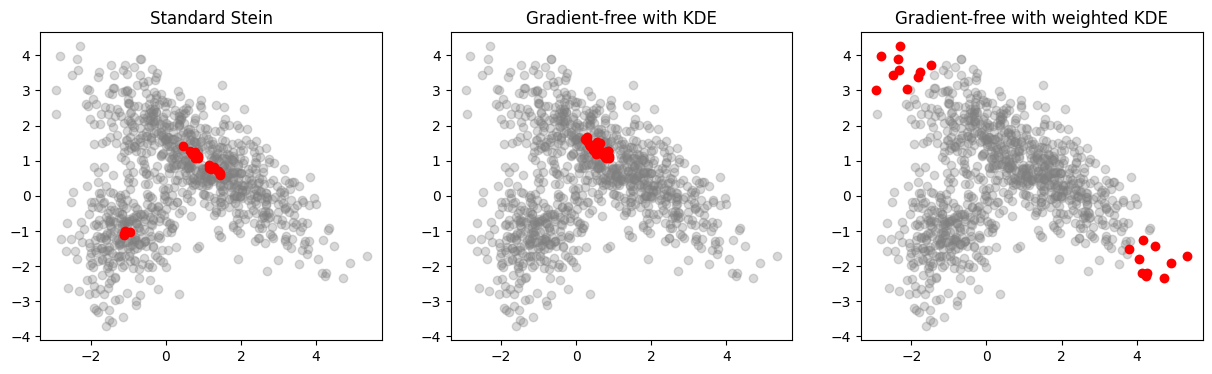

In [57]:
titles = ['Standard Stein', 'Gradient-free with KDE', 'Gradient-free with weighted KDE']
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, km in enumerate(kmats):
    highlight_points(
        sample,
        np.argsort(np.abs(np.diag(km)))[:20],
        coord_spec=[(0, 1)],
        axs=[axs[i]],
        sample_point_color='grey',
        sample_point_size=None,
    );
    axs[i].set_title(titles[i]);

By contrast, the norm of the gradient is reasonably well approximated by both the KDE and the weighted KDE choices:

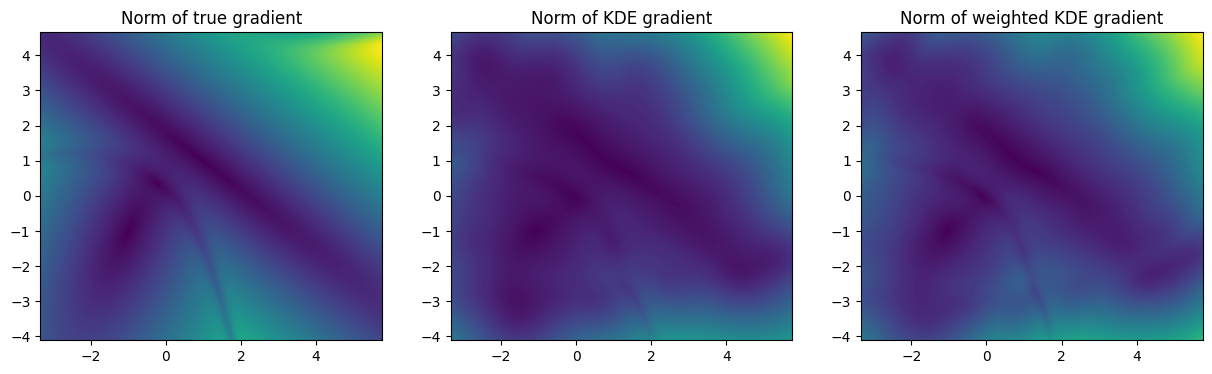

In [58]:
kde_grad = grad(lambda x: kde.logpdf(x)[0])
wkde_grad = grad(lambda x: wkde.logpdf(x)[0])

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plot_density(lambda x: np.linalg.norm(score(x), axis=1), axs[0], xlim, ylim, 'Norm of true gradient');
plot_density(lambda x: np.linalg.norm(jnp.apply_along_axis(kde_grad, 1, x), axis=1), axs[1], xlim, ylim, 'Norm of KDE gradient');
plot_density(lambda x: np.linalg.norm(jnp.apply_along_axis(wkde_grad, 1, x), axis=1), axs[2], xlim, ylim, 'Norm of weighted KDE gradient');

### Performance of the Laplace approximation

We have seen above that the Laplace approximation fails to produce a good proxy for this sample. Here we confirm that the problem again is that the ratio $q(x) / p(x)$ becomes very small for some points.

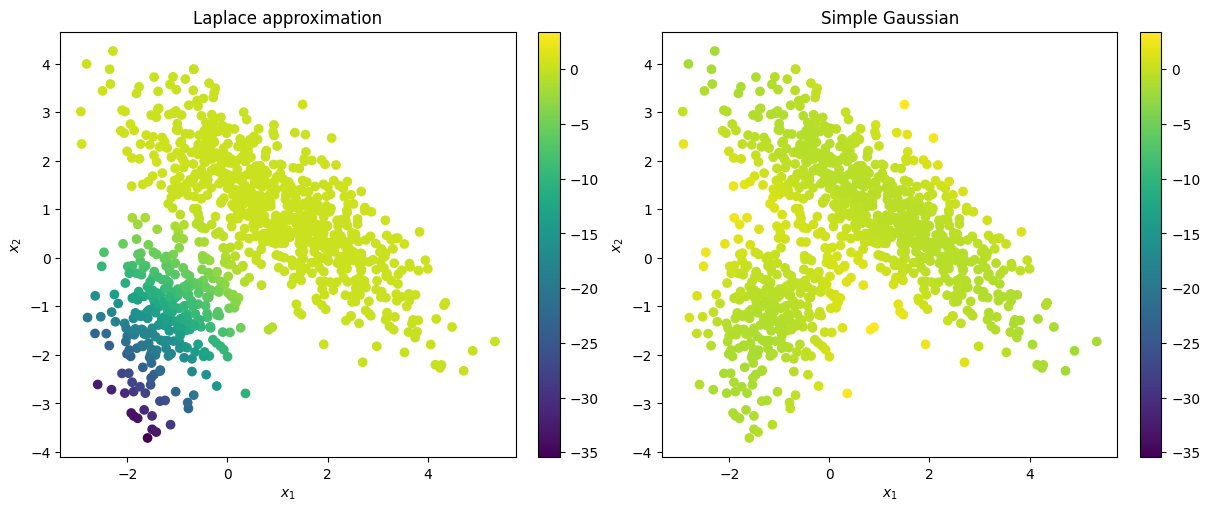

In [59]:
vals = np.concatenate([log_q - log_p, log_q_laplace - log_p])
vmin = np.min(vals)
vmax = np.max(vals)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True);

scatter = axs[0].scatter(sample[:, 0], sample[:, 1], c=log_q_laplace - log_p, vmin=vmin, vmax=vmax);
axs[0].set_title('Laplace approximation');
axs[0].set_xlabel('$x_1$');
axs[0].set_ylabel('$x_2$');
fig.colorbar(scatter, ax=axs[0]);

scatter = axs[1].scatter(sample[:, 0], sample[:, 1], c=log_q - log_p, vmin=vmin, vmax=vmax);
axs[1].set_title('Simple Gaussian');
axs[1].set_xlabel('$x_1$');
axs[1].set_ylabel('$x_2$');
fig.colorbar(scatter, ax=axs[1]);

fig.savefig(figures_path / 'gaussian-mixture-laplace-proxy.pdf');

In [60]:
integrand = _make_stein_integrand(sample, gradient_q_laplace)
km = kmat(integrand, sample.shape[0])
km_vals = km[np.triu_indices_from(km)]

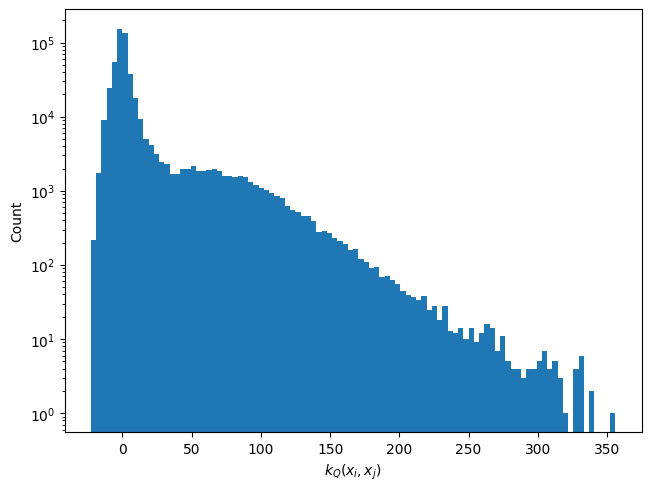

In [61]:
fig, ax = plt.subplots(constrained_layout=True)
ax.hist(km_vals, bins=100);
ax.set_yscale('log');
ax.set_xlabel('$k_Q(x_i, x_j)$');
ax.set_ylabel('Count');

fig.savefig(figures_path / 'gaussian-mixture-kQ-hist.pdf');

In [63]:
np.min(km_vals)

-22.843525681148968

In [64]:
np.max(km_vals)

356.09025856685986

In [65]:
np.exp(-35)

6.305116760146989e-16